In [152]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shapereader
import xarray as XR
import metpy
from metpy.units import units
import metpy.calc as mpcalc
#from mpl_toolkits.basemap import cm
import sys # to get argv
import os
import warnings
warnings.filterwarnings('ignore')

In [311]:
#---読み込むデータの設定-------
#argvs = sys.argv
#nc =  argvs[1] 
nc = '../data/lfm/4v-lfm_lfmkyushu_2021-07-09_15utc.nc'
it = 0    # 時刻スライス(0:解析値, >=1:予測値)
#it = 1    # 時刻スライス(0:解析値, >=1:予測値)
x = 129.789176; y = 31.778707 # 下甑島WVL
zmin = 0; zmax = 5000 # 可視化範囲

In [344]:
#--- データの読み込み------------------
#xr  = XR.open_dataset(nc).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))

xr0  = XR.open_dataset(nc)
xr = xr0.sel(LON=x, method='nearest').sel(LAT=y, method='nearest')
#xr["RH"].transpose("LEV", "TIME").plot()
xr

<xarray.Dataset>
Dimensions:  (TIME: 11, LEV: 16)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2021-07-09T15:00:00 ... 2021-07-10T01:00:00
  * LEV      (LEV) float64 1e+03 975.0 950.0 925.0 ... 250.0 200.0 150.0 100.0
    LAT      float64 31.76
    LON      float64 129.8
Data variables:
    T        (TIME, LEV) float32 ...
    RH       (TIME, LEV) float32 ...
    U        (TIME, LEV) float32 ...
    V        (TIME, LEV) float32 ...
    OMEGA    (TIME, LEV) float32 ...
    Z        (TIME, LEV) float32 ...
Attributes:
    Conventions:  COARDS
    history:      created by lfm2nc version 1.3

In [330]:
# 確認描画
#xr0["RH"].isel(TIME=it).sel(LEV=950).plot()

In [331]:
rh = xr["RH"]
u  = xr["U"]
v  = xr["V"]
T  = xr["T"]
Z  = xr["Z"]
P  = xr["LEV"]

In [343]:
#---水蒸気混合比の計算(Tとpから計算)-------------------
rh0 = rh.isel(TIME=it)
T0  = T.isel(TIME=it)
Z0  = Z.isel(TIME=it)
tp = lev * units.hPa
qvs = (mpcalc.saturation_mixing_ratio(tp, T0) * 1000).metpy.dequantify().rename("QVS").assign_attrs(units="g/kg", long_name="Saturation mixising ratio")
qv = (qvs * rh0 / 100.0).rename("QV").assign_attrs(long_name="Water vapor mixising ratio")
#qv

In [336]:
#---指定したZ座標に補間する------------------------
# xarray.Dataset.assign_coords
# https://xarray.pydata.org/en/stable/generated/xarray.Dataset.assign_coords.html
qv2 = qv.assign_coords(LEV=("LEV", Z0.data))

# Interpolating data
# https://docs.xarray.dev/en/stable/user-guide/interpolation.html
z_interp =  [250, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 
             7000, 8000, 9000, 100000, 110000, 120000, 130000, 140000, 150000]
qv3 = qv2.interp(LEV=z_interp)

fig_4v-lmf_qv_z.png


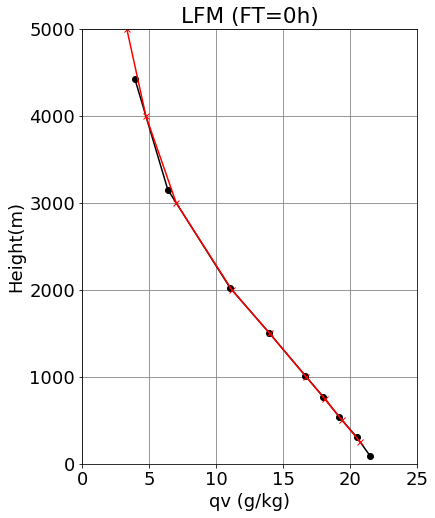

In [347]:
#---図の設定-------------
fs = 18
plt.rcParams["font.size"]   = fs
#plt.rcParams["font.family"] = "fontname"

#---プロット領域の作成-----------
#fig = plt.figure()
#fig = plt.figure(figsize=(4,6))
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(1, 1, 1)

#---lineを描く-------------------
# ax を使わない場合
#qv_cut.plot.line(y="LEV", aspect=0.75, size=8, color='black', marker='o')

# ax を使う場合
#  * ax を定義しておけば、軸が異なるxarrayでも適切にプロットできる
qv2.sel(LEV=slice(zmin, zmax)).plot.line(ax=ax, y="LEV", color='black', marker='o')
qv3.sel(LEV=slice(zmin, zmax)).plot.line(ax=ax, y="LEV", color='r', marker='x')

plt.title("LFM (FT="+str(it)+"h)")
plt.ylabel("Height(m)")
plt.xlabel("qv (g/kg)")
plt.grid(which='major',color='gray',linestyle='-')
ax.set_xlim([0,25])
ax.set_ylim([zmin,zmax])

#------------------------------------
# 図のファイルへの書き出し
#from pathlib import Path
#exe = Path().resolve().split(".")[0] #.replace("draw", "")
#exe = os.path.basename(__file__).split(".")[0] #.replace("draw", "")
fig_name = "fig_4v-lmf_qv_z.png"
#fig_name = "fig_" + exe + ".png"
print(fig_name)
plt.savefig(fig_name, dpi=300, bbox_inches='tight')
plt.show()

In [338]:
qv.to_netcdf("qv.nc")   # p座標
qv2.to_netcdf("qv2.nc") # z座標(ジオポテンシャルハイトそのもの)
qv3.to_netcdf("qv3.nc") # z座標(ジオポテンシャルハイトを指定した高度に内挿したもの）

In [339]:
# plt.plotで描画する場合
#da = qv_cut
#plt.plot(da, da["LEV"], 'o')
#plt.plot(da, da["LEV"], '-')


In [328]:
# HEIGHTという座標を追加してみた
qv_height = qv.assign_coords(HEIGHT=("LEV", Z0.data)) # ジオポテンシャル高度をHEIGHTという座標に追加
qv_height

<xarray.DataArray 'QV' (LEV: 16)>
array([21.522373  , 20.488     , 19.19717   , 17.98524   , 16.66415   ,
       13.958513  , 11.029725  ,  6.3900533 ,  3.9374702 ,  2.4008243 ,
        1.22265   ,  0.38185823,         nan,         nan,         nan,
               nan], dtype=float32)
Coordinates:
    TIME     datetime64[ns] 2021-07-09T15:00:00
  * LEV      (LEV) float64 1e+03 975.0 950.0 925.0 ... 250.0 200.0 150.0 100.0
    LAT      float64 31.76
    LON      float64 129.8
    HEIGHT   (LEV) float32 85.33 309.5 538.3 ... 1.251e+04 1.432e+04 1.674e+04
Attributes:
    long_name:  Water vapor mixising ratio

In [329]:
# 以下はエラーとなる
qv_height.interp(HEIGHT=z_interp)

ValueError: Dimensions {'HEIGHT'} do not exist. Expected one or more of Frozen({'LEV': 16})